# Video Captioning Model

## Shivani Khandelwal

### Import all the libraries

In [4]:
import os
import ast
import glob
import string
import pickle
from pickle import load
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [5]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open('Flickr8k_text/Flickr8k.token.txt', 'r') as fp:
    max_length = 0
    for line in fp.read().split('\n'):
        tok = line.split()
        if len(line) >= 2:
            id = tok[0].split('.')[0]
            desc = tok[1:]

            # Cleanup description
            desc = [word.lower() for word in desc]
            desc = [w.translate(null_punct) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            max_length = max(max_length,len(desc))

            if id not in lookup:
                lookup[id] = list()
                lookup[id].append(' '.join(desc))

In [6]:
lex = set()
for key in lookup:
    [lex.update(d.split()) for d in lookup[key]]

In [7]:
print(len(lookup)) # How many unique word
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
4473
32


In [8]:
img = glob.glob(os.path.join('./','Flickr8k_Dataset/Flicker8k_Dataset', '*.jpg'))

In [9]:
len(img)

8091

In [10]:
train_images_path = os.path.join('./','Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))

test_images_path = os.path.join('./','Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
    f = os.path.split(i)[-1]
    if f in train_images: 
        train_img.append(f) 
    elif f in test_images:
        test_img.append(f)

In [11]:
print(len(train_images))
print(len(test_images))

6000
1000


In [19]:
START = 'start'
STOP = 'end'
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
    for d in range(len(v)):
        v[d] = f'{START} {v[d]} {STOP}'

In [20]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048

encode_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 149, 149, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 149, 149, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 149, 149, 32) 0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

In [21]:
def encodeImage(img):
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = encode_model.predict(x) 
    x = np.reshape(x, OUTPUT_DIM)
    return x

In [22]:
train_path = os.path.join('./', "data", f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
    encoding_train = {}
    for id in tqdm(train_img):
        image_path = os.path.join('./','Flickr8k_Dataset/Flicker8k_Dataset', id)
        img = load_img(image_path, target_size=(HEIGHT, WIDTH))
        encoding_train[id] = encodeImage(img)
    with open(train_path, "wb") as fp:
        pickle.dump(encoding_train, fp)
else:
    with open(train_path, "rb") as fp:
        encoding_train = pickle.load(fp)

In [23]:
test_path = os.path.join('./',"data", f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
    encoding_test = {}
    for id in tqdm(test_img):
        image_path = os.path.join('./','Flickr8k_Dataset/Flicker8k_Dataset', id)
        img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        encoding_test[id] = encodeImage(img)
    with open(test_path, "wb") as fp:
        pickle.dump(encoding_test, fp)
else:
      with open(test_path, "rb") as fp:
        encoding_test = pickle.load(fp)

In [24]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

6000

In [25]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 3845 ==> 601


In [26]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 2
vocab_size

603

In [27]:
with open('data/wordtoidx.txt', 'w') as file:
    file.write(str(wordtoidx))
    
with open('data/idxtoword.txt', 'w') as file:
    file.write(str(idxtoword))

In [28]:
max_length +=2
print(max_length)

34


In [29]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
    # x1 - Training data for photos
    # x2 - The caption that goes with each photo
    # y - The predicted rest of the caption
    x1, x2, y = [], [], []
    n=0
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            # Each photo has 5 descriptions
            for desc in desc_list:
            # Convert each word into a list of sequences.
                seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
            # Generate a training case for every possible sequence and outcome
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([np.array(x1), np.array(x2)], np.array(y))
                x1, x2, y = [], [], []
                n=0

In [31]:
embeddings_index = {} 
f = open(os.path.join('./', 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [02:34, 2590.83it/s] 


Found 400000 word vectors.


In [30]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

NameError: name 'embeddings_index' is not defined

In [22]:
embedding_matrix.shape

(603, 200)

In [23]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [24]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      120600      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [25]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [26]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [27]:
EPOCHS = 10
model_path = os.path.join("./","data",f'caption-model.hdf5')

if not os.path.exists(model_path):
    for i in tqdm(range(EPOCHS*2)):
        generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
        caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    caption_model.optimizer.lr = 1e-4
    number_pics_per_bath = 6
    steps = len(train_descriptions)//number_pics_per_bath

    for i in range(EPOCHS):
        generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
        caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
        
    caption_model.save_weights(model_path)
    print("Training...")
else:
    caption_model.load_weights(model_path)

In [28]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

./Flickr8k_Dataset/Flicker8k_Dataset\1056338697_4f7d7ce270.jpg


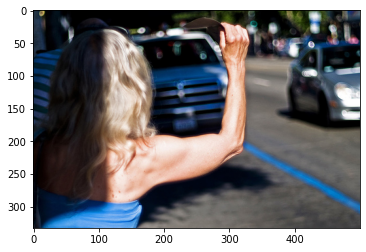

Caption: girl in pink shirt is sitting on the grass by the sandy
_____________________________________
./Flickr8k_Dataset/Flicker8k_Dataset\106490881_5a2dd9b7bd.jpg


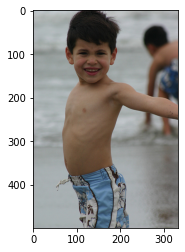

Caption: boy in blue shirt and plays laying carrying small snowboard
_____________________________________


In [29]:
for z in range(2):
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,OUTPUT_DIM))
    print(os.path.join('./','Flickr8k_Dataset/Flicker8k_Dataset', pic))
    x=plt.imread(os.path.join('./','Flickr8k_Dataset/Flicker8k_Dataset', pic))
    plt.imshow(x)
    plt.show()
    print("Caption:", generateCaption(image))
    print("_____________________________________")

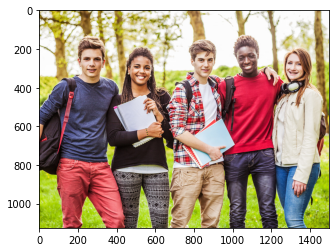

(1, 2048)
Caption: group of people are standing in front of building
_____________________________________


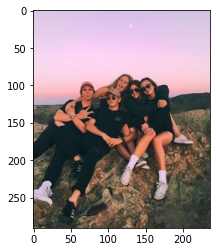

(1, 2048)
Caption: man in plays sunglasses is standing on riding of looking at the there
_____________________________________


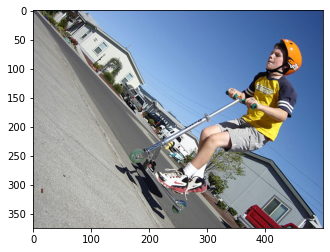

(1, 2048)
Caption: boy in green shirt is jumping over fence
_____________________________________


In [30]:
urls = ['Sample_Image4.jpg', 'Sample_Image3.jpg', 'Sample_Image6.jpg']

for url in urls:
    img = Image.open(url)
    img.load()

    plt.imshow(img)
    plt.show()
    
    img = encodeImage(img).reshape((1,OUTPUT_DIM))
    print(img.shape)
    print("Caption:",generateCaption(img))
    print("_____________________________________")

### Image Captioning

In [31]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048

max_length = 34
with open('data/wordtoidx.txt') as f:
    data = f.read()
wordtoidx = ast.literal_eval(data)

with open('data/idxtoword.txt') as f:
    data = f.read()
idxtoword = ast.literal_eval(data)

def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

def extract_features(img):
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = encode_model.predict(x)
    x = np.reshape(x, OUTPUT_DIM )
    return x

inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

caption_model.load_weights('data/caption-model.hdf5')
img_file = Image.open('Sample_Image1.jpg')
img = extract_features(img_file).reshape((1,OUTPUT_DIM))

print("Caption:",generateCaption(img))

Caption: boy in blue shirt is dry close with drinking fence


### Video captioning

In [ ]:
import cv2
import numpy as np
import ast
import numpy as np
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add

encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048

max_length = 34
with open('data/wordtoidx.txt') as f:
    data = f.read()
wordtoidx = ast.literal_eval(data)

with open('data/idxtoword.txt') as f:
    data = f.read()
idxtoword = ast.literal_eval(data)

vocab_size = len(idxtoword) + 1
embedding_dim = 200

def generateCaption(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

def extract_features(img):
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = encode_model.predict(x)
    x = np.reshape(x, OUTPUT_DIM)
    return x

inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

caption_model.load_weights('data/caption-model.hdf5')

video = cv2.VideoCapture('1.mp4')
width1 = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height1 = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
threshold = 100.

writer = cv2.VideoWriter('Output_video.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 25, (width1, height1))
ret, frame1 = video.read()
current_frame = frame1
caption = ''

while True:
    ret, frame = video.read()
    if ret is True:
        if (((np.sum(np.absolute(frame-current_frame))/np.size(frame)) > threshold)):
            img_file = Image.fromarray(frame)
            img = extract_features(img_file).reshape((1,OUTPUT_DIM))
            caption = generateCaption(img)
            print("Caption:", caption)
            current_frame = frame
        else:
            current_frame = frame

        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, caption, (10,350), font, 0.5, (255,0,0), 1, cv2.LINE_AA)
        cv2.imshow('frame', frame)
        writer.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    if ret is False:
        break

video.release()
writer.release()
cv2.destroyAllWindows()